# Text classification with LSTM (RNN)

## Import Libraries

In [295]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
# import plotly.plotly as py
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
import matplotlib as mpl
from matplotlib import pyplot
import os
import jieba # 中文分词组件
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\idgca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Import data

In [296]:
def read_data(rootdir, target_name, target_index):
    
    for root, subdirs, files in os.walk(rootdir):
        for file in files:
            path = root+'/'+file
            with open(path, encoding="utf8") as f:
                input_file = f.read()
                data.append(input_file)
                target_names.append(target_name)
                target.append(target_index)

data = []
target_names = []
target = []
read_data("data/classification_data_v3/中性", "中性", 0)
read_data("data/classification_data_v3/买入", "买入", 1)
read_data("data/classification_data_v3/卖出", "卖出", 2)

In [297]:
# combine data to single dataframe
df_raw = pd.DataFrame()
df_raw['data'] = data
df_raw['target_names'] = target_names
df_raw['target'] = target


In [298]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23769 entries, 0 to 23768
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   data          23769 non-null  object
 1   target_names  23769 non-null  object
 2   target        23769 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 557.2+ KB


In [299]:
df_raw.target_names.value_counts()
df_raw.target.value_counts()

买入    17123
中性     6634
卖出       12
Name: target_names, dtype: int64

1    17123
0     6634
2       12
Name: target, dtype: int64

In [300]:
df_raw.head()

,data,target_names,target
0,\n \n \n \n[Table_main] 公司研究类模板 \n 顺丰控股(0023...,中性,0
1,公\n司\n研\n究 DONGXING SECURITIES \n \n华域汽车（6007...,中性,0
2,\n \n公 汽车和汽车零部件 \n \n司 2020 年 02 月 24日 \n报 长城...,中性,0
3,\n \n仅供机构投资者使用 \n证券研究报告|公司点评报告 \n [Table_2D0a...,中性,0
4,\n \n \n证券研究报告 \n公司研究/公告点评 \n2020年02月24日 基础化工...,中性,0


## Data exploration

In [151]:
df_raw['target_names'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Documents', 
                                                                title='Number of Documents in each category')

In [322]:
df = df_raw

In [153]:
# audit dataframe (check for nulls)
def table_info(data):
    tab_info=pd.DataFrame(data.dtypes).T.rename(index={0:'column type'})
    tab_info=tab_info.append(pd.DataFrame(data.isnull().sum()).T.rename(index={0:'null values (nb)'}))
    tab_info=tab_info.append(pd.DataFrame(data.isnull().sum()/data.shape[0]*100).T.rename(index={0:'null values (%)'}))
    return tab_info

table_info(df)

,data,target_names,target
column type,object,object,int64
null values (nb),0,0,0
null values (%),0,0,0


## Data preprocessing

In [154]:
# print one sample
def print_data(index):
    example = df[df.index == index][['data', 'target_names']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])

print_data(100)

 
 
 
公司报告 | 年报点评报告 
  
中科创达（300496） 证券研究报告  2020年 02月 27日 
投资评级 
5G应用核心标的，报表继续验证高景气度！ 行业 计算机/计算机应用 
6个月评级 增持（维持评级） 
  
事件 当前价格 68.15元 
目标价格  元 
公司发布年报，2019 年营收 18.27 亿元，同比增长 24.74%，归母净利润  
2.38亿元，同比增长 44.63%。 
 基本数据 
19年业绩整体符合预期，维持快速增长 A股总股本(百万股) 402.52 
流通 A股股本(百万股) 283.19  
公司实现归母净利润 2.38亿元，同比增长约 45%，位于此前业绩预告中值
A股总市值(百万元) 27,431.40 
47%附近，符合市场预期。扣非后净利润高增主要与收入端高增有关，公  
司实现收入 18.27亿元，同比增长 24.74%，整体符合预期。结构看，手机/ 流通 A股市值(百万元) 19,299.49  
汽车/物联网业务同比增长 14%/72%/13%。公司布局新一代网联汽车业务， 每股净资产(元) 4.76 
市场渗透率提升，收入持续高速增长。公司整体毛利率上升 0.92个百分点， 资产负债率(%) 30.41 
考虑商业模式逐步变化，我们看好新业务汽车软件毛利率持续改善，投入 一 年内最高/最低(元) 79.90/25.73 
产出比提升。  
20年 Q1扣非业绩增长 43%略超预期  作者 
沈海兵 分析师 
公司发布 20Q1 业绩预告，业绩增速预计中值约 30%符合预期，扣非业绩 SAC执业证书编号：S1110517030001 
有望达 6000万，同比增长 43%略超预期。收入保持高增长，预计超 30%， shenhaibing@tfzq.com 
我们判断主要与物联网业务出货加速和汽车业务保持高速增长有关，业务 缪欣君 分析师 
面向全球，19年海外收入占比 56%，公司通过远程协同办公等方式发力海 SAC执业证书编号：S1110517080003 
外业务，受疫情影响有限。 miaoxinjun@tfzq.com  
潘暕 分析师 
20年基本面有望逐季加速，高度看好 SAC执业证书编号：S1110517070005 
 panjian@tfzq.com 
5G 应用三大赛道景气度推

In [155]:
df_backup = df

In [366]:
df = df_backup.sample(n = 2000) 
df = df.reset_index(drop=True)
df.target_names.value_counts()

买入    1459
中性     541
Name: target_names, dtype: int64

In [236]:
df_sample = df
df_sample.target_names.value_counts()

买入    1468
中性     532
Name: target_names, dtype: int64

In [275]:
df = df_sample

In [ ]:
# df = df_raw
# df['data'] = df['data'].map(lambda x: x.lstrip('+-').rstrip('aAbBcC'))
# df.to_csv(r'data/classification_data_v3/removed_newline.csv',header=True,index=None)


In [367]:
file_name = 'data/classification_data_v3/dict.txt'
jieba.load_userdict(file_name) # 自定义词汇
# df = df_raw
# remove special characters and punctuation
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;.。%-]')
STOPWORDS = {"的","和","\n"," "} # set(stopwords.words('english'))
def clean_text(text):
#     text = REPLACE_BY_SPACE_RE.sub(' ', text)
#     text = re.compile('[，（）%％《》、:：]').sub(' ', text)
#     text = ''.join(re.findall(r'[\u4e00-\u9fa5]', text)) # only chinese words
#     wordlist = jieba.lcut(text, cut_all=False) # partition
#     text = ' '.join(word for word in wordlist if word not in STOPWORDS) # combine
#     re.sub('[\n\t\s]*',' ',text)
    text = text.replace('\n','')
    text = text.replace('\0', '')
    text = text.replace('\t', ' ')
    return text

df['data'] = df['data'].apply(clean_text)
# df['data'] = df['data'].str.replace('\d+', '') # remove all digits
# df.to_csv(r'data/classification_data_v3/removed_newline.csv',header=True,index=None,  encoding='utf-8')

In [368]:
df.to_csv(r'data/classification_data_v3/removed_newline_v4.csv',header=True,index=None,  encoding='utf_8_sig', sep='\t')
df.head()


,data,target_names,target
0,证券研究报告 | 季报点评 2020 年 04 月 29 日 阳光电源（300274.SZ...,中性,0
1,华[Ta熙bl生e_物T（itl6e8]8 363）2019年报点评 公 司研...,中性,0
2,证券研究报告 | 半年报点评 2020 年 09 月 01 日 韵达股份（002120.S...,买入,1
3,[Table_StockInfo] 2020 年 04 月 30 日 买入 （维持） 证...,买入,1
4,[Table_main] 公司研究类模板 中联重科(000157) 报告日期：...,买入,1


In [369]:
train_index = np.random.rand(len(df)) < 0.8
test_index = ~train_index


df_train = df[train_index].reset_index(drop=True)
df_test = df[test_index].reset_index(drop=True)

In [370]:
train_index = np.random.rand(len(df_train)) < 0.8
val_index = ~train_index

df_train_2 = df_train[train_index].reset_index(drop=True)
df_val = df_train[val_index].reset_index(drop=True)

In [371]:
df_train_2
len(df_train_2)
len(df_test)
len(df_val)

,data,target_names,target
0,证券研究报告 | 半年报点评 2020 年 09 月 01 日 韵达股份（002120.S...,买入,1
1,[Table_StockInfo] 2020 年 04 月 30 日 买入 （维持） 证...,买入,1
2,[Table_main] 公司研究类模板 中联重科(000157) 报告日期：...,买入,1
3,证券研究报告 公司研究/深度研究 2020年03月27日 家用电器/白色家电Ⅱ 投资评...,买入,1
4,汽车 报告原因：中报点评 2020 年 8 月 31 日 公司近一年市场表现 市场数...,买入,1
...,...,...,...
1305,证券研究报告 ...,买入,1
1306,[Table_Page] 公告点评|食品饮料 证券研究报告 [Table_Titl...,买入,1
1307,证券研究报告|首次覆盖报告 2020 年 08 月 06 日 泰格医药（300347.SZ...,买入,1
1308,分析师:唐俊男 登记编码：S0730519050003 中期业绩高增，精细化管理凸...,中性,0


1310

392

298

In [373]:
df_train_2.to_csv(r'data/classification_data_v3/removed_newline_v4_train.csv',
          header=False,
          index=None,  
          encoding='utf_8_sig', 
          sep='\t')
df_test.to_csv(r'data/classification_data_v3/removed_newline_v4_test.csv',
          header=False,
          index=None,  
          encoding='utf_8_sig', 
          sep='\t')
df_val.to_csv(r'data/classification_data_v3/removed_newline_v4_val.csv',
          header=False,
          index=None,  
          encoding='utf_8_sig', 
          sep='\t')

In [374]:
df_test = pd.read_csv(r'data/classification_data_v3/removed_newline_v4_val.csv',header=None,sep='\t')
df_test.head()

,0,1,2
0,证券研究报告 | 季报点评 2020 年 04 月 29 日 阳光电源（300274.SZ...,中性,0
1,2020 年 4 月 30 日 春秋航空（601021.SH） 交...,中性,0
2,[Table_Message]2 020-04-27 公司点评报告 公 买入/维持 司古...,买入,1
3,[晶Tab盛le_机Titl电e] (300316) 公司研究/点评报告 订单厚增业绩，光...,买入,1
4,2020 年 8 月 28 日 苏泊尔（002032.SZ） 家电...,买入,1


In [357]:
import csv
import sys
maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)
i=0
with open('data/classification_data_v3/removed_newline_v3_val.csv', encoding="utf8") as f:
    reader = csv.reader(f, delimiter="\t")
    for line in reader:
        print(len(line[0]))
        i=i+1

922337203

8182
28177
9978
5991
8133
8484
8455
8117
7214
5513
9668
8152
10405
25182
6061
6180
17974
3139
8078
7006
5965
35942
7840
5641
6535
5642
6615
8407
8318
6480
5791
7977
7460
6852
7526
7605
9067
4337
3878
7655
9160
7528
6239
7869
8249
6035
6776
5079
7938
33389
3401
10587
41099
10368
6937
7192
35479
9673
40287
48018
33121
13274
8862
42762
5786
12541
8250
6096
6409
7916
26877
31593
8539
9382
6662
9602
31249
6318
8359
7555
10043
9821
5086
33985
10031
6282
34381
7986
18478
36245
6652
4891
20555
5458
9463
9285
12279
6671
6516
10934
8477
10916
17173
11743
11516
10459
8140
5978
16236
6359
9343
6952
10850
31282
9517
7944
9836
7348
5370
25150
11280
6472
7352
8996
9834
7431
8907
9710
7251
11484
5218
10669
7824
5910
8948
7061
9608
10350
7864
7474
23639
29351
6727
7282
9223
9339
32855
8591
6009
7368
9428
5865
8902
14839
11676
6965
7507
30947
4538
9770
5381
12524
6276
6668
11123
6061
6993
6524
14213
8282
6678
5791
9130
14698
5475
5520
7511
5142
11950
5659
27357
5784
7765
6499
11290
13332
14253
6369
2362

7211
14929
36580
4283
10342
7192
10801
7672
10332
16265
27189
7493
8573
7662
7386
3935
6570
9342
6820
11256
8490
8870
6369
6766
9107
7656
8539
11028
7466
7296
18523
10746
7661
6751
16381
14380
6718
8171
13931
6753
9305
16875
10344
28727
4442
9202
9682
8242
8010
6434
8334
6427
14499
12192
9938
8120
9358
8372
6972
7598
19281
8910
6607
3194
3658
7983
8277
17454
6860
7362
14691
6895
6494
7273
6849
39155
28941
6114
7219
10865
8044
8294
10140
5035
10098
9782
13736
7660
5927
7963
13917
7567
5953
12688
6301
13557
7883
8156
10779
7775
5528
8705
9044
20155
7727
10221
6562
7341
20337
10290
14563
7117
44664
9010
7836
6484
12717
6970
5520
9651
10044
9919
7557
8976
3875
6844
17452
4858
8010
29720
8877
8912
7819
13363
10169
17351
9027
12784
6855
7484
8235
7486
8497
7587
8004
13626
11259
9544
8286
6268
7380
6840
9829
12278
6263
4812
7851
3328
7742
8302
9878
7276
9406
9331
13431
5980
3890
7456
13656
3864
10458
8090
11387
10732
8415
9110
9155
8077
6798
8423
6853
10026
9095
9142
7384
6242
5006
4112
9527


5746
10010
6277
10235
7430
5351
6104
3977
7558
8450
7099
7100
7231
7188
8218
7514
13502
4248
5129
11580
11859
6207
8378
10474
10641
10067
10157
8549
8158
4251
7751
10489
14049
23697
7804
6173
12946
14332
7327
12854
33354
5933
11498
10976
7649
8056
8279
10330
7557
8447
7532
8379
5909
7577
17389
7582
8693
6738
7299
8244
9334
9000
9778
3900
10217
6399
10569
5050
11000
8762
8478
9961
10542
9586
10345
9913
8599
7441
9385
7219
8256
6463
10840
4760
8000
8834
15303
9657
6912
9302
9868
15837
8387
7222
8961
7976
10119
7822
11767
8301
13105
32133
10180
13966
14919
8647
7767
10036
9692
8183
8697
6633
8394
8103
7184
6961
5910
14397
8192
12470
5262
10582
6303
5619
7477
7603
12607
4419
6788
6515
10275
8037
7734
4723
8782
7474
14130
7991
11648
6796
8044
9736
31836
8531
7789
11403
4022
9293
14933
8225
7755
5536
7218
56875
4197
8627
8193
10170
0
0
9497
6773
8382
7820
6438
9143
7058
8790
6760
7276
6565
12711
5742
6204
8913
6547
6058
6427
9666
13294
27076
6023
35938
8854
13342
33937
8809
7478
11062
10856


In [277]:
def print_data(index):
    example = df[df.index == index][['data', 'target_names']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])

print_data(9)

证券 研究 报告 | 首次 覆盖 报告 2020 年 03 月 12 日 中科 三环 （ 000970 . SZ ） 磁材 领域 龙头企业 ， 新能源 车 开启 公司 成长 新篇章 钕铁硼 永磁 材料 龙头企业 ， 行业 发展 领路人 。 公司 从事 钕铁硼 稀土 永磁 材 增持 （ 首次 ） 料 新兴 磁性材料 研发 、 生产 销售 ， 是 全球 最大 钕铁硼 永磁体 制造商 股票 信息 之一 。 公司 成长 驱动 因素 在于 研发 能力 驱动 下 对 新 应用领域 率先 切入 放量 抢占 。 行业 金属 非金属 新 材料 最新 收盘价 10.16 新能源 汽车 推动 磁材 行业 迎来 新一轮 成长 。 国家 鼓励 高性能 钕铁硼 永磁 产 总 市值 ( 百万元 ) 10 , 822.43 业 发展 ， 节能 环保 政策 提供 了 广阔 发展 空间 ， 根据 测算 ， 未来 三年 高 总 股本 ( 百万 股 ) 1 , 065.20 性能 钕铁硼 年均 消费 增速 维持 在 15% 左右 ， 其中 新能源 汽车 是 消费 核 其中 自由 流通股 ( % ) 100.00 心 增量 ， 占 比 有望 从 2018 年 12% 提升 至 2022 年 30% 。 此外 ， 工业 30 日 日均 成交量 ( 百万 股 ) 31.55 机器人 、 汽车 零部件 、 风电 、 节能 家电 以及 消费 电子 等 领域 也 将 稳定增长 。 股价 走势 技术 研发 能力 突出 ， 新能源 汽车 领域 先发 优势 明显 。 中国 是 钕铁硼 主要 生产 地 ， 国内 企业 资源 及 成本 优势 显著 。 公司 通过 对 工艺 、 技术 、 设备 等 中科 三环 沪 深 300 方面 改进 不断 提升 产品 竞争力 。 目前 公司 已 成为 特斯拉 驱动 电机 供 37% 应商 ， 先发 优势 明显 ， 未来 随着 特斯拉 Model 3 放量 以及 海外 车企 积 27% 极 布局 ， 市场份额 有望 进一步 提升 。 18% 9% 参股 南方 稀土 ， 中重 稀土 供应 能力 加强 。 2019 年 4 月 公司 拟 参股 南方 稀 0% 土 5% 股份 ， 南方 稀土 将 以 市场 最 优惠 价格 向 中科 三环 提供 稀土 原材 - 9% 料 ， 同时 双方 也 将 在 赣

In [213]:
def print_data(index):
    example = df[df.index == index][['data', 'target_names']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])

print_data(9)

Table _ Page 公告 点评 白色 家电 证券 研究 报告 Table _ Title Table _ Invest 买入 华帝 股份  SZ 公司 评级 当前 价格   元 收入 增速 单季 转正 全年 盈利 能力 继续 提升 合理 价值   元 前次 评级 买入 Table _ Summary 报告 日期    核心 观点  公司 披露  年 业绩 快报 收入 增速 单季 转正 但单 季度 盈利 能力 有 相 Ta 对 ble 市 _ Pi 场 cQu 表 ote 现 所 下降 预计  年 公司 实现 收入   亿元 YoY   实现 归 母 净利润   亿元 YoY +   对应 净利润率   YoY  +  pct ； 其中 第四季度 实现 收入   亿元 YoY +   实现 归母  净利润   亿元 YoY   对应 净利润率   YoY  pct    年 商品房 住宅 竣工 滞后 导致 厨电 终端 需求 承压  年 有望 回  暖 奥维云 网全 渠道 推总 数据 显示  年 油烟机 燃气灶 消毒柜  行业 零售量 分别 同比       在 竣工 滞后 影响 下 表现                低迷 ； 同时 价格 也 承受 了 较大 压力 中怡康 数据 显示  年 油烟 华帝 股份 沪 深  机 燃气灶 消毒柜 行业 线下 零售 均价 分别 同比       华帝 相应 零售 均价 分别 同比       整体 略 好 于 行业 分 Ta 析 ble 师 _ A uth or 曾婵  工程 渠道 放量 与 电商 收入 确认 节奏 短期 变化 或 影响 单 季度 盈利 能力 SAC 执 证号 S 公司 四季度 盈利 能力 短暂 小幅 下滑 我们 认为 公司 前期 大力发展 工 SFC CE No BNV 程 渠道 目前 毛利率 仍然 偏低 同时 高 毛利率 电商 渠道 收入 部分 因双   十一 促销 前移 等 因素 被 提前 确认 导致 单 季度 毛利率 有所 下降 zengchan gf com cn  盈利 预测 投资 建议 预计 公司   年 归母 净利润 为     分析师 袁雨辰   亿元 同比 增长       最新 收盘价 对应  年 SAC 执 证号 S PE 估值  x 仍 处于 近 五年 来 估值 底部 尽管

## jieba library functions

In [85]:
wordlist = jieba.lcut(temp)
text = nltk.Text(wordlist)
print(text)

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\idgca\AppData\Local\Temp\jieba.cache
Loading model cost 0.718 seconds.
Prefix dict has been built successfully.


<Text: 公司 报告 年报 点评 报告 中科 创达 证券...>


In [88]:
# 搜索上下文
text.concordance(word='报告',width=20,lines=10)

Displaying 10 of 33 matches:
公司 报告 年报 点评 报告
报告 年报 点评 报告 中科 创达 证券
创达 证券 研究 报告 年月日 投资 评
贝格 数据 相关 报告 中科 创达 季报
免责 申明 公司 报告 年报 点评 报告
报告 年报 点评 报告 财务 预测 摘要
免责 申明 公司 报告 年报 点评 报告
报告 年报 点评 报告 分析师 声明 本
分析师 声明 本 报告 署名 分析师 在
 胜任 能力 本 报告 所 表述 的 所


In [92]:
# 搜索共同上下文
text.common_contexts(['报告','公司'])
# 统计词频
text.count(word='报告')

No common contexts were found


33

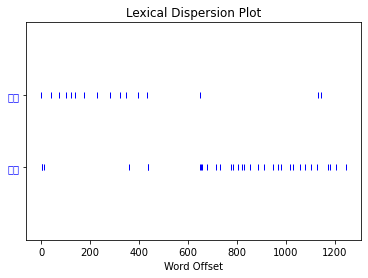

In [94]:
# 离散图
words=['公司','报告']
text.dispersion_plot(words)

In [97]:
# 计算相似度
text.similar(word='报告',num=10)

from nltk.text import ContextIndex
contentindex = ContextIndex(wordlist)
similarity_scores = contentindex.word_similarity_dict(word='报告')
for key,value in similarity_scores.items():
    if value>0.02:
        print(key,value)

发布
报告 1.0
发布 0.08333333333333333


## Tokenize documents

In [283]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 3000
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer( filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True) #num_words=MAX_NB_WORDS,
tokenizer.fit_on_texts(df['data'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 106335 unique tokens.


## Save processed data to csv

In [240]:
# df.to_csv(r'data/classification_data_v3/cleaned.csv',header=True,index=None)

In [284]:
def count_text(text):
    return len(text.split(' '))
    
df['word_count'] = df.data.apply(count_text)
df['word_count']

0       9545
1       2565
2       2687
3       2610
4       4243
        ... 
1995    1418
1996    3295
1997    3483
1998    2906
1999    2897
Name: word_count, Length: 2000, dtype: int64

In [285]:
np.mean(df['word_count']) # each document has average 2500 words after processing 

4161.997

## Get train test datasets

In [286]:
X = tokenizer.texts_to_sequences(df['data'].values)


In [291]:
MAX_SEQUENCE_LENGTH = 10000
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH) # , maxlen=MAX_SEQUENCE_LENGTH
print('Shape of data tensor:', X.shape)

Shape of data tensor: (2000, 10000)


In [292]:
Y = pd.get_dummies(df['target']).values
Y_single = df['target']
print('Shape of label tensor:', Y.shape)
print('Shape of label tensor:', Y_single.shape)

Shape of label tensor: (2000, 2)
Shape of label tensor: (2000,)



## Train test split

In [293]:
# X = df['data']
# Y = df['target']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1600, 10000) (1600, 2)
(400, 10000) (400, 2)


## LSTM

In [294]:
def create_model(
                units=100,
                dropout=0.1,
                recurrent_dropout=0.1,
                loss='binary_crossentropy',
                optimizer='adam',
                dense_units=2,
                activation='sigmoid'
                ):
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    # units: Positive integer, dimensionality of the output space.
    # dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs
    # recurrent_dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state
    model.add(LSTM(units, dropout=dropout, recurrent_dropout=recurrent_dropout))
    # units: Positive integer, dimensionality of the output space
    # (None, 3)
    model.add(Dense(dense_units, activation=activation))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

epochs = 2
batch_size = 64

# clf = KerasRegressor(build_fn=create_model, verbose=0, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

pipeline = Pipeline([
    ('clf',clf)
])

# history = pipeline.fit(X_train, Y_train)
history = create_model().fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 1440 samples, validate on 160 samples
Epoch 1/2


InvalidArgumentError:  indices[40,7916] = 92230 is not in [0, 50000)
	 [[node embedding_15/embedding_lookup (defined at C:\Users\idgca\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3007) ]] [Op:__inference_keras_scratch_graph_29735]

Function call stack:
keras_scratch_graph


Trails Results:
1. sample data includes numbers, added a few stop words and common phrases, 3 epoch
    1. sample data only includes 2 cases
    2. val_accuracy: 0.7688
    3. test_accuracy: 0.565
    4. naive_base: 0.575
    
2. sample data removes numbers, 3 epoch
    1. val_accuracy: 0.7437
    3. test_accuracy: 0.499
    4. naive_base: 0.65
3. no processing, 3 epoch
    1. val_accuracy: 0.7500
    3. test_accuracy: 0.526
    4. naive_base: 0.585

In [254]:
# predicted = pipeline.predict(X_test)
# # print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(predicted[0],predicted[1]))
# predicted

predicted = create_model().evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(predicted[0],predicted[1]))


400/400 [==============================] - 2s 4ms/step
Test set
  Loss: 0.692
  Accuracy: 0.550


In [184]:
np.mean(predicted == Y_test)

0.0

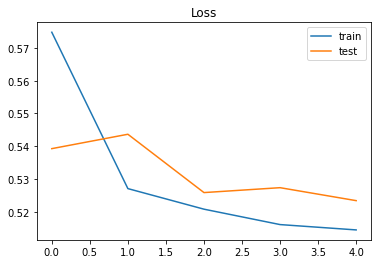

In [155]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

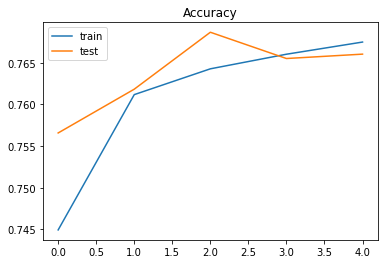

In [162]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [160]:
history.history


{'val_loss': [0.5392549102489379,
  0.5436472492889902,
  0.5258472341844336,
  0.527341907144721,
  0.5233879128841196],
 'val_accuracy': [0.7565720081329346,
  0.761829674243927,
  0.768664538860321,
  0.7655099630355835,
  0.7660357356071472],
 'loss': [0.5747780097204527,
  0.5270597410879122,
  0.5207833287097748,
  0.5160820137149704,
  0.5144538231555816],
 'accuracy': [0.74493074, 0.7611757, 0.76427275, 0.76602584, 0.7674867]}

In [210]:
pred = model.predict((X_test)) # [28:29,:]
pred

array([[2.7217430e-01, 7.2757405e-01, 2.5159252e-04],
       [2.7305761e-01, 7.2667521e-01, 2.6714511e-04],
       [1.8111259e-01, 8.1873506e-01, 1.5236292e-04],
       ...,
       [1.7219770e-01, 8.2754946e-01, 2.5281697e-04],
       [1.7943431e-01, 8.2046747e-01, 9.8176388e-05],
       [1.7481382e-01, 8.2509303e-01, 9.3145696e-05]], dtype=float32)

## Naive base

In [279]:
# pipeline
text_clf_nb = Pipeline([
                        ('vect', CountVectorizer(lowercase=False)), # attribute stop_words ("then, the, etc.")
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB(alpha=0.01)), # FitPrior=False, a uniform prior will be used
                    ])

In [280]:
X_train, X_test, Y_single_train, Y_single_test = train_test_split(X,Y_single, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_single_train.shape)
print(X_test.shape,Y_single_test.shape)

(1600,) (1600,)
(400,) (400,)


In [281]:
text_clf_nb = text_clf_nb.fit(X_train, Y_single_train)

In [282]:
predicted = text_clf_nb.predict(X_test)
np.mean(predicted == Y_single_test)

0.7525